# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Yue Lin

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [231]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [232]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

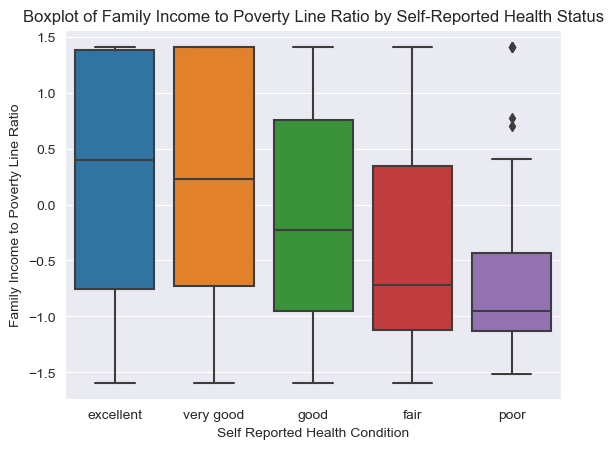

In [233]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

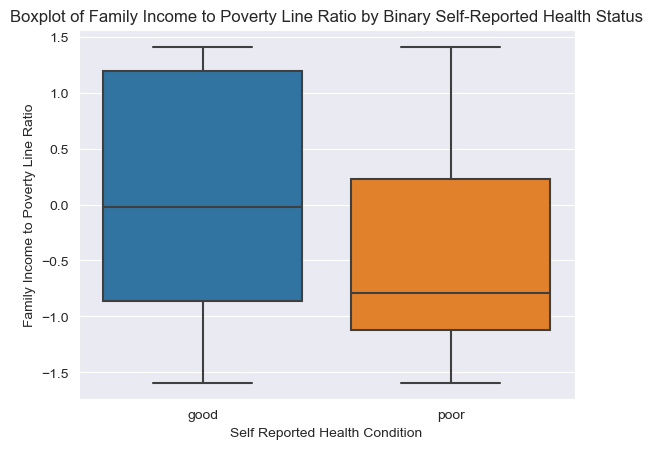

In [234]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

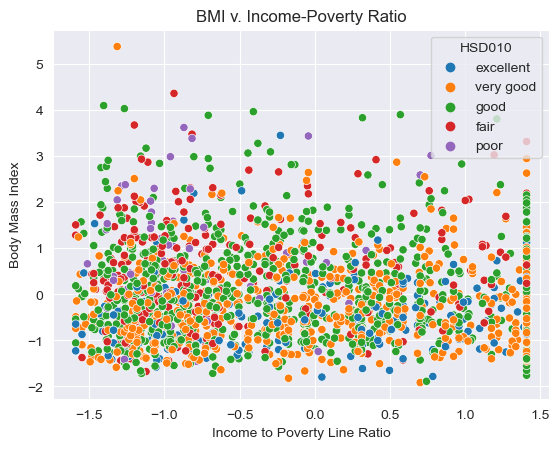

In [235]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [236]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

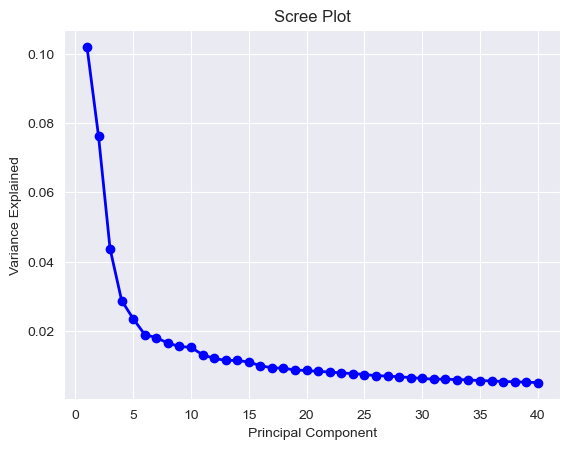

In [237]:
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA(40) 
principalComponents = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [238]:
# apply PCA based on the scree plot, where the sixth component indicates a sharp "diminishing return" in terms of explained variance
pca = PCA(n_components=6) 
principalComponents = pca.fit_transform(nhanes_scaled)

In [239]:
# convert into a dataframe
pca_df = pd.DataFrame(data = principalComponents, 
                      columns = ['pc 1', 
                                 'pc 2',
                                'pc 3',
                                'pc 4',
                                'pc 5',
                                'pc 6'])

In [240]:
# view factor loadings as dataframe
pca_df.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6
0,9.527811,-0.816224,-1.867062,-2.109256,-3.927957,-0.168776
1,-5.838339,-3.692572,3.805778,-1.028964,0.394038,1.605212
2,-0.719454,-2.573200,0.907925,-4.754829,-1.798320,0.878374
3,3.533627,-2.576983,-3.249111,-0.404858,4.001667,1.439675
4,-6.872094,-4.194240,0.886839,-0.848634,-0.525837,0.077863


I chose six principal components because based on the scree plot, the biggest drop off where we see diminishing returns (the "elbow") in the scree plot seems to be around 6.

### Barplot of Components

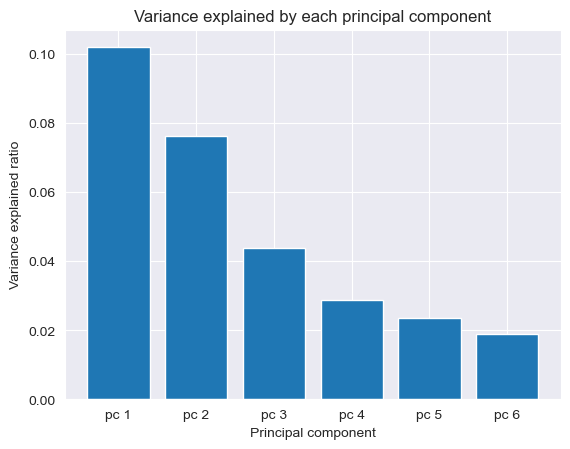

In [241]:
# draw a barplot
plt.bar(pca_df.columns, pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.xlabel('Principal component')
plt.ylabel('Variance explained ratio')
plt.show()

### How many components will you use to fit a supervised learning model?

I choose six components to fit a supervised learning model. This is because we need to choose the number of components corresponding to the elbow point as the optimal number for my supervised learning model. The first six components can explain a large number of variance, and the 6th component indicates a sharp "diminishing return" in terms of explained variance. 

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

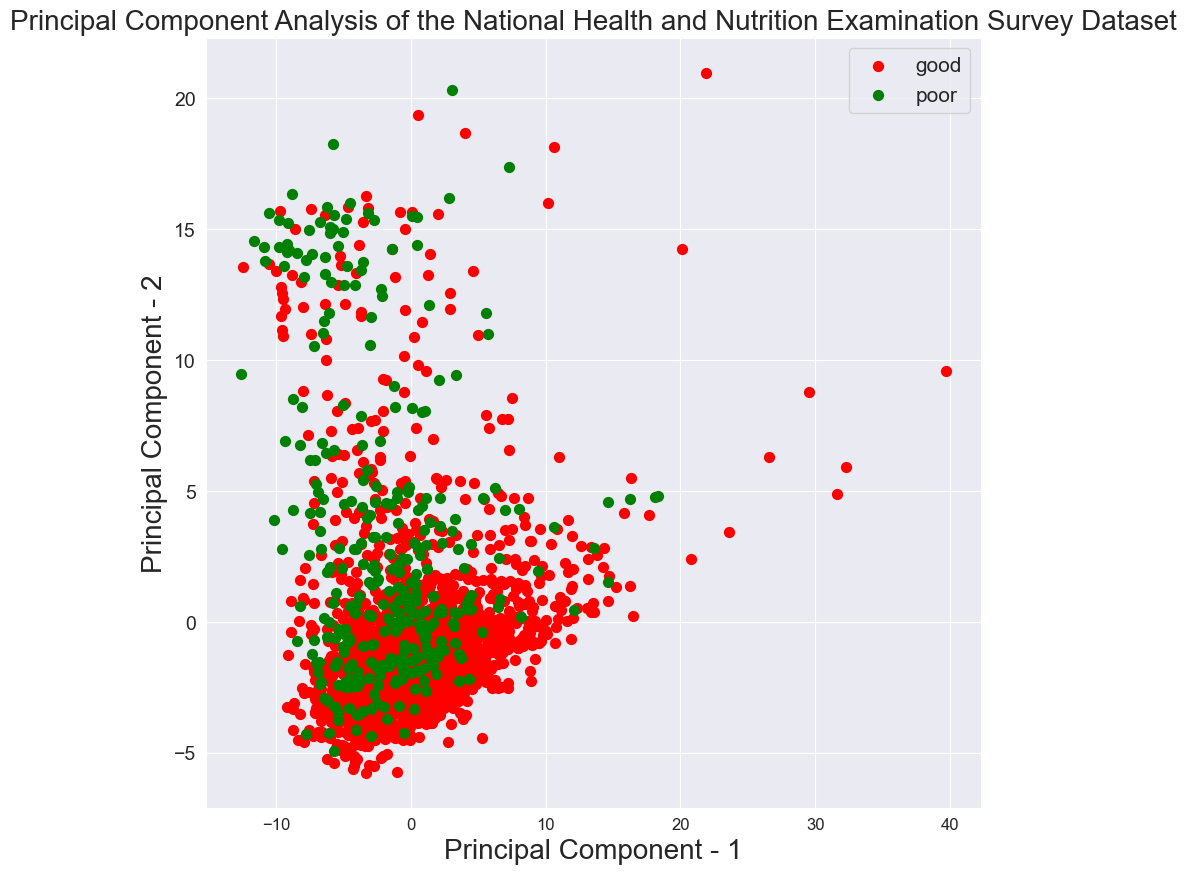

In [242]:
# plot
# ----------

nhanes_scaled['HSD010_binary'] = hsd010_binary  
nhanes_scaled.reset_index(inplace=True)

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of the National Health and Nutrition Examination Survey Dataset",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = nhanes_scaled['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc 1']
               , pca_df.loc[indicesToKeep, 'pc 2'], c=color, s=50, label = target)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

Analysis: data points in the two colored groups have many overlaps, indicating that the two principal components cannot effectively capture the variability that distinguishes the groups in my data.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I choose k-means clustering because k-means minimizes the within-cluster sum of squares, making it a metric-based clustering algorithm. K-means is also computationally efficient and scales well with large datasets. For large datasets like NHANES, K-means can be a practical choice compared to more computationally intensive algorithms.

### Cluster nhanes

In [243]:
# set random seed
np.random.seed(10)

In [244]:
# one-hot encode categorical columns
nhanes_encoded = pd.get_dummies(nhanes_scaled)

# standardize the data
scaler = StandardScaler()
nhanes_standardized = scaler.fit_transform(nhanes_encoded)

/Users/yuelin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yuelin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yuelin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yuelin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

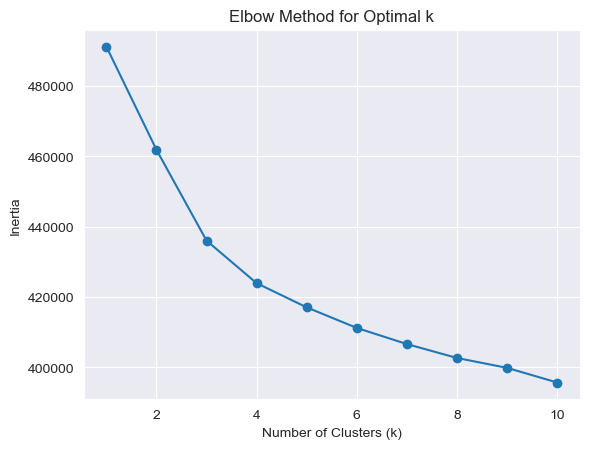

In [245]:
# create an empty list to store the inertia values
inertia = []

# define the range of k values to try
k_values = range(1, 11) 

# fit k-means for each k and calculate the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_standardized)  
    inertia.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [273]:
kmeans = KMeans(
    n_clusters=4,
    n_init=10,   #number of times the k-means algorithm is run with different centroid seeds 
                 #10 if using init='random' or init is a callable
    max_iter=300
)

# fit the k-means model to the standardized data
kmeans.fit(nhanes_standardized)

KMeans(n_clusters=4, n_init=10)

In elbow method, inertia indicates the sum of squared distances from each data point to cluster center. As shown in the scree plot above, we should choose 4 as the number of clusters (k=4). When k is greater than 4, the benefits of having more clusters will decrease (i.e., inertia will change more slowly).

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

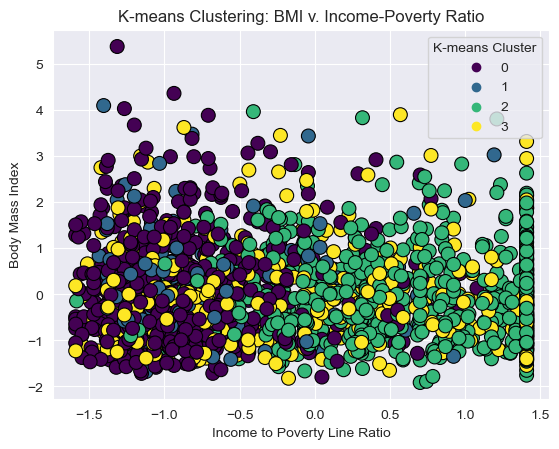

In [276]:
# apply k-means clusters on top of the BMI v. Income Poverty Ratio Plot
plt.figure()
ax = sns.scatterplot(x=nhanes_scaled["INDFMPIR"], y=nhanes_scaled["BMXBMI"], hue=kmeans.labels_, palette='viridis', marker='o', s=100, edgecolor='k')
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("K-means Clustering: BMI v. Income-Poverty Ratio")
ax.legend(title="K-means Cluster", loc="upper right")  # Specify legend explicitly
plt.show()

Cluster 3 (yellow) seems to align with the pattern of the poor health condition (orange) in the BMI v.s. Income-Poverty Ratio plot.

However, although there is a slightly distinguishable clustering pattern between cluster 1 (blue) and 2 (green), the overall clusters are not very explicitly demarcated.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [277]:
# retrain clustering
kmeans = KMeans(
    n_clusters=4,
    n_init=10,   
    max_iter=300)

# now fit k-means to PCA components
kmeans.fit(principalComponents)

KMeans(n_clusters=4, n_init=10)

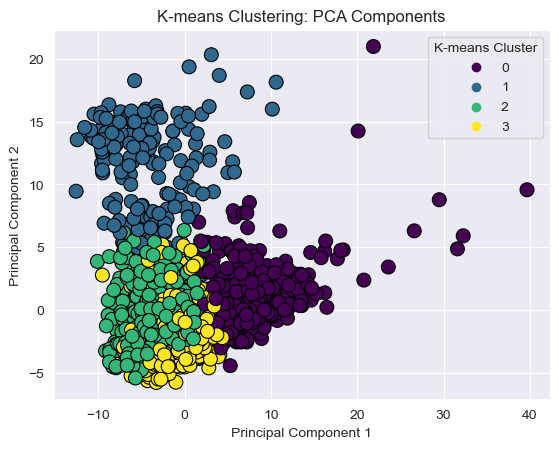

In [278]:
# plot k-means clusters on top of the PCA scatterplot
plt.figure()
ax = sns.scatterplot(x=pca_df["pc 1"], y=pca_df["pc 2"], hue=kmeans.labels_, palette='viridis', marker='o', s=100, edgecolor='k')
ax.set(xlabel="Principal Component 1", ylabel="Principal Component 2")
ax.set_title("K-means Clustering: PCA Components")
ax.legend(title="K-means Cluster", loc="upper right")  # Specify legend explicitly
plt.show()

After overlaying k-means over PCA components, we now have a much better clustering result! The four clusters demonstrate a more explicit and distinguishable pattern. The overall clustering pattern closely resembles the PCA pattern.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [284]:
print(hsd010_binary.unique())

['good' 'poor']


In [308]:
# convert to numeric, using either hsd010 or hsd010_binary
hsd010_binary_encoded = pd.get_dummies(nhanes_scaled['HSD010_binary'], prefix='hsd010_binary')

In [309]:
# partition data
# -----------
y = hsd010_binary_encoded 
X = nhanes_scaled.drop(['HSD010_binary'], axis = 1) # drop out any columns that aren't features

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [311]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = y_train.shape[1]

In [312]:
# create neural network model
# -----------
model = Sequential()

# hidden layer with 'relu' activation
model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

# output layer with 'softmax' activation 
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

In [313]:
## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 0s - loss: 462.3816 - accuracy: 0.1641 - val_loss: 382.5867 - val_accuracy: 0.1512 - 360ms/epoch - 45ms/step
Epoch 2/10
8/8 - 0s - loss: 314.6368 - accuracy: 0.1641 - val_loss: 232.3686 - val_accuracy: 0.1512 - 28ms/epoch - 3ms/step
Epoch 3/10
8/8 - 0s - loss: 164.8411 - accuracy: 0.1641 - val_loss: 77.4910 - val_accuracy: 0.1512 - 24ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 26.7204 - accuracy: 0.4922 - val_loss: 11.8968 - val_accuracy: 0.8488 - 24ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 18.1620 - accuracy: 0.8359 - val_loss: 20.8900 - val_accuracy: 0.8488 - 25ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 22.3706 - accuracy: 0.8359 - val_loss: 19.3860 - val_accuracy: 0.8488 - 28ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 18.3333 - accuracy: 0.8359 - val_loss: 13.1025 - val_accuracy: 0.8488 - 38ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 10.6865 - accuracy: 0.8359 - val_loss: 5.3437 - val_accuracy: 0.8488 - 29ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0

Interpretation: as it feeds more data through the network, the validation scores improve but only up to a certain point (around 0.8488).

### Neural Network on Principal Components

In [325]:
# partition data
# -----------
y = hsd010_binary_encoded 
X = principalComponents

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [327]:
num_classes = y_train.shape[1]

model = Sequential()

# hidden layer 
model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

# output layer 
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 0s - loss: 0.6930 - accuracy: 0.5827 - val_loss: 0.6892 - val_accuracy: 0.8198 - 322ms/epoch - 40ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6865 - accuracy: 0.8320 - val_loss: 0.6826 - val_accuracy: 0.8488 - 29ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6805 - accuracy: 0.8359 - val_loss: 0.6765 - val_accuracy: 0.8488 - 24ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6749 - accuracy: 0.8359 - val_loss: 0.6707 - val_accuracy: 0.8488 - 22ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6694 - accuracy: 0.8359 - val_loss: 0.6648 - val_accuracy: 0.8488 - 22ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6638 - accuracy: 0.8359 - val_loss: 0.6586 - val_accuracy: 0.8488 - 22ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6575 - accuracy: 0.8359 - val_loss: 0.6518 - val_accuracy: 0.8488 - 23ms/epoch - 3ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6507 - accuracy: 0.8359 - val_loss: 0.6440 - val_accuracy: 0.8488 - 30ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6425 - a

Interpretation: as it feeds more data through the network, the validation scores slightly improve from 0.8198 to 0.8488, as indicated in 'val_accuracy.' 

### Neural Network on Principal Components + Cluster Membership

In [330]:
# partition data
# -----------
y = hsd010_binary_encoded 
X = principalComponents

cluster_labels = kmeans.labels_

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10,
                                                    stratify=cluster_labels)

num_classes = y_train.shape[1]

model = Sequential()

# hidden layer 
model.add(Dense(num_classes, input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

# output layer 
model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 0s - loss: 0.6882 - accuracy: 0.7745 - val_loss: 0.6830 - val_accuracy: 0.8372 - 266ms/epoch - 33ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6805 - accuracy: 0.8372 - val_loss: 0.6747 - val_accuracy: 0.8566 - 26ms/epoch - 3ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6727 - accuracy: 0.8333 - val_loss: 0.6664 - val_accuracy: 0.8566 - 22ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6651 - accuracy: 0.8333 - val_loss: 0.6578 - val_accuracy: 0.8566 - 23ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6572 - accuracy: 0.8333 - val_loss: 0.6490 - val_accuracy: 0.8566 - 22ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6489 - accuracy: 0.8333 - val_loss: 0.6399 - val_accuracy: 0.8566 - 23ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6404 - accuracy: 0.8333 - val_loss: 0.6304 - val_accuracy: 0.8566 - 31ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6318 - accuracy: 0.8333 - val_loss: 0.6206 - val_accuracy: 0.8566 - 32ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6228 - a

Interpretation: as it feeds more data through the network, the validation scores improves much more, though only up to a certain point (i.e., 0.8566).

**Overall interpretation**: this last algorithm, which trains a neural network based on PCA components and k-means membership, performs the best among all. It has the highest validation accuracy, indicating that the model is generalizing well to unseen data. It also has the lowest loss validation loss (e.g., when epoch approaches 10/10), indicating that the model is improving its ability to make predictions.

Regarding featurization technique, the neural network trained on PCA-transformed data and k-means clustering membership seems to be capturing important patterns in the data. The last algorithm also captures both k-means cluster information and PCA-induced reduced-dimensional representation. 

However, to make a more comprehensive evaluation, we will need to assess the performance of each algorithm using metrics such as accuracy, precision, recall, F1 score, or AUC-ROC, which we learned in previous lectures. As for large dataset like nhanes, the prediction ability of an algorithm is quite important. Hence, given the well performance of the last algorithm on validation accuracy and loss, I believe that we need to use the neural network trained both on PCA-transformed data and k-means clustering membership.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Answers:
1. PCA aims to reduce dimensionality by transforming the original features into a new set of uncorrelated variables. By contrast, clustering aims to group similar data points together based on the similarity of their features.
2. PCA produces a new set of variables (i.e., principal components) that capture the most significant variance in the data. However, clustering produces clusters of orginial data points that share similarities.
3. PCA is often used for simplifying complex datasets and identifying patterns in exploratory data analysis, and it is suitable in scenarios where there are many correlated variables (e.g., feature engineering). Meanwhile, clustering is often used for exploratory data analysis and pattern recognition.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Answers:
yes, combining PCA and clustering can offer several advantages:
1. Clustering in high-dimensional spaces can be challenging to interpret. By applying PCA before clustering, we can transform the data into a lower-dimensional space, making it easier to visualize and interpret the cluster structures.
2. PCA helps in identifying and reducing noise or irrelevant features in the data. This can improve the quality of clustering by focusing on the most relevant information and reducing the impact of less informative variables.
3. Clustering might perform better when applied to PCA rather than the original features. As is in the nhanes dataset, there could be multicollinearity (high correlations) among the original features, which can be addressed by PCA.
4. When computational resources are limited, clustering on a reduced set of principal components can lead to faster computations compared to clustering on the entire set of original features.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Answers:
overall, unsupervised techniques are useful for preprocessing, understanding, and enhancing big data, making it more amenable for downstream supervised learning tasks.
1. Big data often involves a large number of features, which can lead to the curse of dimensionality and increased computational complexity. To solve this problem, unsupervised techniques like PCA can be used for dimensionality reduction.
2. Big data may contain noisy or irrelevant features, and manually selecting relevant features can be challenging and time-consuming. Unsupervised techniques like clustering can help identify groups of similar features or patterns in the data, aiding in the creation of meaningful aggregated features. This is what we learned as "feature engineering" in the last lab.
3. Understanding the structure and patterns in big data can be challenging. Techniques like clustering can help uncover underlying structures, relationships, or groups in the data, providing insights that guide the selection of appropriate supervised learning models and strategies.
4. Big data might contain outliers or anomalies that can adversely affect the performance of supervised models. Unsupervised anomaly detection techniques can identify unusual patterns or outliers in the data, allowing for their proper handling or removal before training a supervised model.
5. Big data may have missing values, duplicates, or other quality issues that need to be addressed. Unsupervised techniques such as clustering or imputation methods can help preprocess the data by handling missing values, detecting duplicates, or addressing other data quality issues.